# Предсказание дождя

### Анализ:
1. Посмотреть, 365 дней - это календарный год? - Да, судя по значениям температуры
2. Заполнить пропущенные данные на тесте - готово
### Фичи:
1. Учитывать предыдущие значения
2. Категориальные - направление ветра, но также ее можно и как числовую
3. Категории числовых переменных
4. Какие то комбинации фичей
5. Солнечные дни
### Предобработка:
1. Фича селекшен - корреляция, индекс общей корреляции
2. Обрезать аномальные значения по IQR
3. Логарифмировать перекошенные данные - для линейных функций
### Обучение:
1. Через трейн тест сплит разделить
2. Обучить отдельно катбуст, добавить категориальные фичи и т.д.
3. Попробовать как временной ряд, учитывать предыдущие значения
4. Изучить подходы для несбалансированных классов
5. Изменить пороги принятия решений
6. Методы повторной выборки (например, SMOTE, недостаточная выборка) или скорректированные веса классов для улучшения баланса
### Модели:
1. Регрессия
2. Бустинги
3. Случаный лес
4. Автомл
5. Нейронки

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from scipy import interpolate

import warnings
import os

# Отключение предупреждений
warnings.filterwarnings("ignore")

# Отключение вывода системных сообщений (для LightGBM, XGBoost и CatBoost)
os.environ["LIGHTGBM_VERBOSE"] = "0"
os.environ["XGBOOST_VERBOSITY"] = "0"
os.environ["CATBOOST_VERBOSE"] = "0"

In [94]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [95]:
train.head(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [96]:
test.head(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


## Анализ

In [97]:
def df_info(df):
    """Вывод информации о датафрейме"""

    print(f'Размер - {df.shape}')
    print(' ')
    print(f'Информация - {df.info()}')

In [98]:
df_info(train)

Размер - (2190, 13)
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB
Информация - None


In [99]:
df_info(test)

Размер - (730, 12)
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             730 non-null    int64  
 1   day            730 non-null    int64  
 2   pressure       730 non-null    float64
 3   maxtemp        730 non-null    float64
 4   temparature    730 non-null    float64
 5   mintemp        730 non-null    float64
 6   dewpoint       730 non-null    float64
 7   humidity       730 non-null    float64
 8   cloud          730 non-null    float64
 9   sunshine       730 non-null    float64
 10  winddirection  729 non-null    float64
 11  windspeed      730 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 68.6 KB
Информация - None


Одно пропущенное значение в поле winddirection.  
Направление ветра - категориальная переменная, поэтому изменим тип поля и заполним модой

In [100]:
def fill_winddirection(train, test):
    """Заполнение пропущенных значений поля winddirection"""

    # Объединяем датасет
    df_full = pd.concat([train, test]).drop(['id'], axis=1)

    # Заполняем пустые значения - модой
    winddirection_mode = df_full['winddirection'].mode()
    df_full['winddirection'] = df_full['winddirection'].fillna(winddirection_mode)
    df_full['winddirection'] = df_full['winddirection'].astype(str)

    # Разделяем обратно на трейн и тест
    train = df_full[df_full['rainfall'].isna()==False]
    test = df_full[df_full['rainfall'].isna()].drop(['rainfall'], axis=1)

    return train, test

In [101]:
train, test = fill_winddirection(train, test)

#### Поле day

In [102]:
def plot_days(df):
    """График распределения поля day"""

    plt.figure(figsize=(16,4))
    ax = sns.countplot(x='day', data=df, width=0.8)

    # Оставляем только нужные метки (каждый 5-й день)
    ax.set_xticks(range(0, len(df['day'].unique()), 10))  

    plt.show()

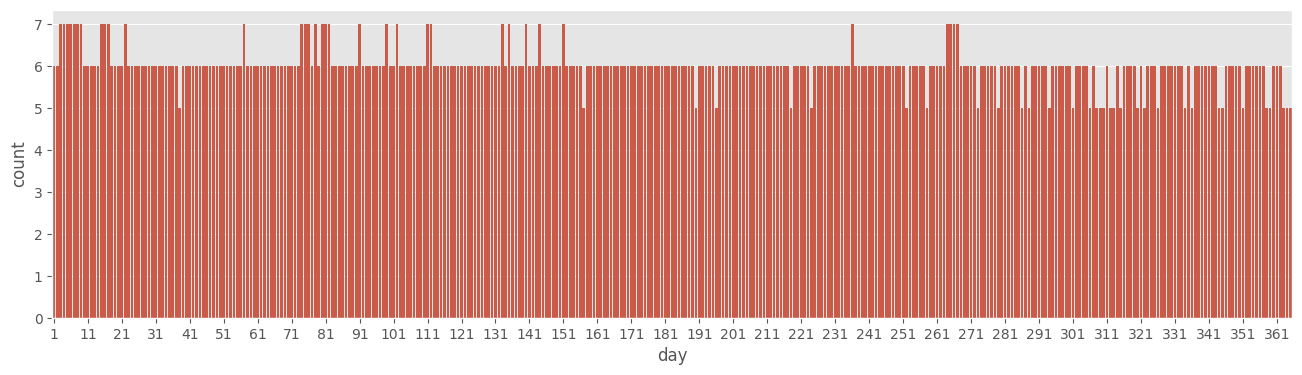

In [103]:
plot_days(train)

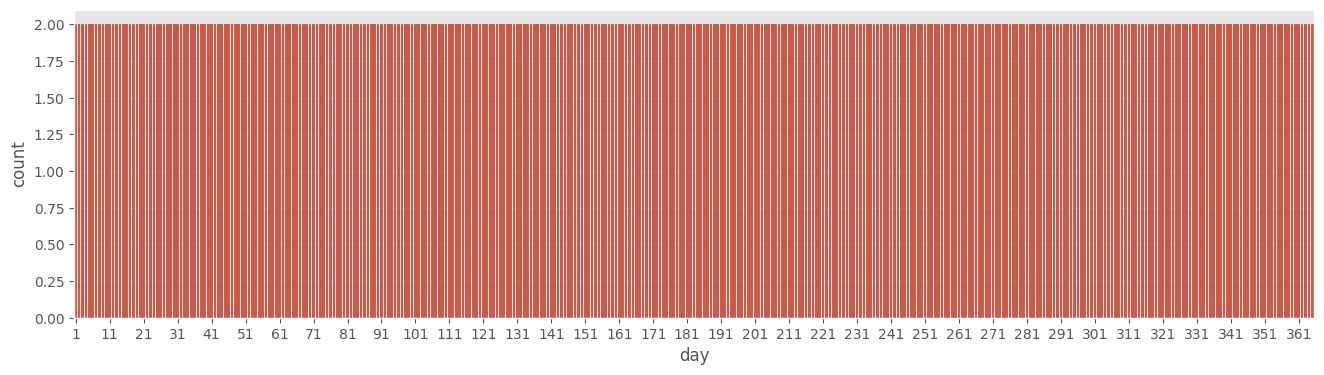

In [104]:
plot_days(test)

В трейне 2190 значений, должно было быть 6 лет показателей (Хотя почему то не учитываются високосные года)  
Но при этом каких то значений 5,6 или 7, надо проверить

In [105]:
def check_wrong_days(df):
    """Проверка на некорректное заполнение поля day"""

    for index, day in df['day'].items():
        if  (index != 2189):
            next_day = df['day'][index+1]
            if (next_day != 1) and (day + 1 != next_day):
                print(f'Индекс - {index}, День - {day}, Следующий день - {next_day}')

In [106]:
check_wrong_days(train)

Индекс - 1036, День - 307, Следующий день - 3
Индекс - 1037, День - 3, Следующий день - 309
Индекс - 1131, День - 37, Следующий день - 265
Индекс - 1132, День - 265, Следующий день - 39
Индекс - 1209, День - 115, Следующий день - 80
Индекс - 1210, День - 80, Следующий день - 117
Индекс - 1250, День - 156, Следующий день - 236
Индекс - 1251, День - 236, Следующий день - 158
Индекс - 1283, День - 189, Следующий день - 4
Индекс - 1284, День - 4, Следующий день - 191
Индекс - 1289, День - 195, Следующий день - 16
Индекс - 1290, День - 16, Следующий день - 197
Индекс - 1311, День - 217, Следующий день - 5
Индекс - 1312, День - 5, Следующий день - 219
Индекс - 1317, День - 223, Следующий день - 6
Индекс - 1318, День - 6, Следующий день - 225
Индекс - 1345, День - 251, Следующий день - 151
Индекс - 1346, День - 151, Следующий день - 253
Индекс - 1351, День - 257, Следующий день - 81
Индекс - 1352, День - 81, Следующий день - 259
Индекс - 1366, День - 272, Следующий день - 264
Индекс - 1367, Д

In [107]:
train.loc[1035:1040,:]

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
1035,306,1016.9,27.5,24.5,23.5,22.4,82.0,88.0,4.5,50.0,24.9,1.0
1036,307,1014.6,25.2,24.8,23.9,21.2,84.0,70.0,2.1,80.0,33.5,1.0
1037,3,1015.2,25.0,23.9,23.6,19.9,76.0,61.0,8.8,90.0,14.1,0.0
1038,309,1017.0,27.7,24.0,22.6,19.6,91.0,78.0,3.3,25.0,16.4,1.0
1039,310,1018.4,26.4,24.4,23.3,23.3,86.0,66.0,9.7,60.0,8.3,1.0
1040,311,1020.2,20.6,19.5,18.2,16.8,86.0,88.0,0.1,60.0,43.8,1.0


Видно что есть косяки с заполнением поля "Day"

In [108]:
def delete_wrong_days(df):
    """Удаление некорректных значений поля day"""

    # Проходим итеративно по датафрейму
    for index in range(df.shape[0]):
        day = df['day'][index]
        
        if (index < 2188) and not pd.isna(day):
            days_iter = 1

            while True:
                # Определяем значение следующего дня
                next_day = df['day'][index+days_iter]
                
                # Если следующий день не совпадает очередностью с предыдущим, то меняем его значение на nan
                if (next_day != 1) and (day + days_iter != next_day):
                    df.loc[index+days_iter, 'day'] = np.nan
                    days_iter += 1
                else:
                    break
    return df

In [109]:
train = delete_wrong_days(train)

In [110]:
train.loc[1033:1039,:]

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
1033,304.0,1015.3,26.0,24.9,23.1,23.2,90.0,83.0,3.5,80.0,24.9,1.0
1034,305.0,1017.7,27.0,25.6,24.0,23.2,86.0,79.0,1.2,20.0,15.3,1.0
1035,306.0,1016.9,27.5,24.5,23.5,22.4,82.0,88.0,4.5,50.0,24.9,1.0
1036,307.0,1014.6,25.2,24.8,23.9,21.2,84.0,70.0,2.1,80.0,33.5,1.0
1037,NaN,1015.2,25.0,23.9,23.6,19.9,76.0,61.0,8.8,90.0,14.1,0.0
1038,309.0,1017.0,27.7,24.0,22.6,19.6,91.0,78.0,3.3,25.0,16.4,1.0
1039,310.0,1018.4,26.4,24.4,23.3,23.3,86.0,66.0,9.7,60.0,8.3,1.0


In [111]:
def fill_empty_days(df):
    """Заполнение пустых значений поля day"""

    # Разделяем датасет по годам
    for year_number in range(6):
    
        df_year = df.loc[365*year_number:364+365*year_number,'day']

        # Интерполираем пропущенные значения в середине года
        days_interpolated = df_year.interpolate(method='polynomial', order=2)
        df.loc[365*year_number:364+365*year_number,'day'] = days_interpolated
        
        df_year_new = df.loc[365*year_number:364+365*year_number,:]
        not_null_days = df_year_new[df_year_new['day'].isna()==False]
        null_days_index = df_year_new[df_year_new['day'].isna()].index

        # Экстраполируем пропущенные значения на концах года
        f = interpolate.interp1d(not_null_days.index, not_null_days['day'], kind='linear', fill_value='extrapolate')
        days_extrapolated = f(null_days_index)
        df.loc[null_days_index,'day'] = days_extrapolated

    df['day'] = round(df['day']).astype(int)
    
    return df

In [112]:
train = fill_empty_days(train)

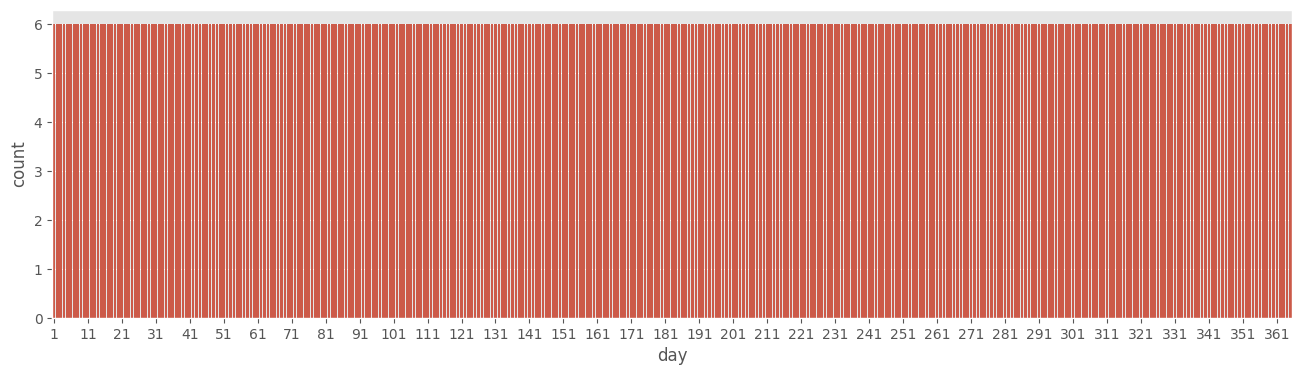

In [113]:
plot_days(train)

In [114]:
check_wrong_days(train)

Теперь все значения поля дат корректные  
Далее проверим, данные являются временным рядом за несколько лет, или набором данных за год из разных мест

#### Распределение числовых показателей

In [115]:
def get_season(date):
    """Определение сезона по месяцу"""

    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def create_date_features(df,  date_start):
    """Формирование фичей дат"""

    # Количество лет в датасете
    number_of_years = int(df.shape[0] / 365)

    # Определяем год
    for year_number in range(number_of_years):

        df_year = df.loc[365*year_number:364+365*year_number,:]
        df.loc[df_year.index, 'year'] = date_start + year_number

    df['year'] = df['year'].astype(int).astype(str)

    # Формирование фичей даты, месяца и сезона
    df['date'] = pd.to_datetime(df['year'] + '-' + df['day'].astype(str), format="%Y-%j")
    df['month'] = df['date'].dt.month
    df['season'] = df['date'].apply(get_season)

    return df

In [116]:
train = create_date_features(train,  2020)
test = create_date_features(test,  2026)

In [117]:
def plot_temparature(train, test):
    """График температуры на трейне и тесте"""

    plt.figure(figsize=(16,6))
    plt.plot(train['date'], train['temparature'], label='Train', color='blue')
    plt.plot(test['date'], test['temparature'], label='Test', color='red')

    plt.xlabel('Date')
    plt.ylabel('temparature')
    plt.title('График температуры на трейне и тесте')
    plt.legend()
    plt.grid(True)

    plt.show()

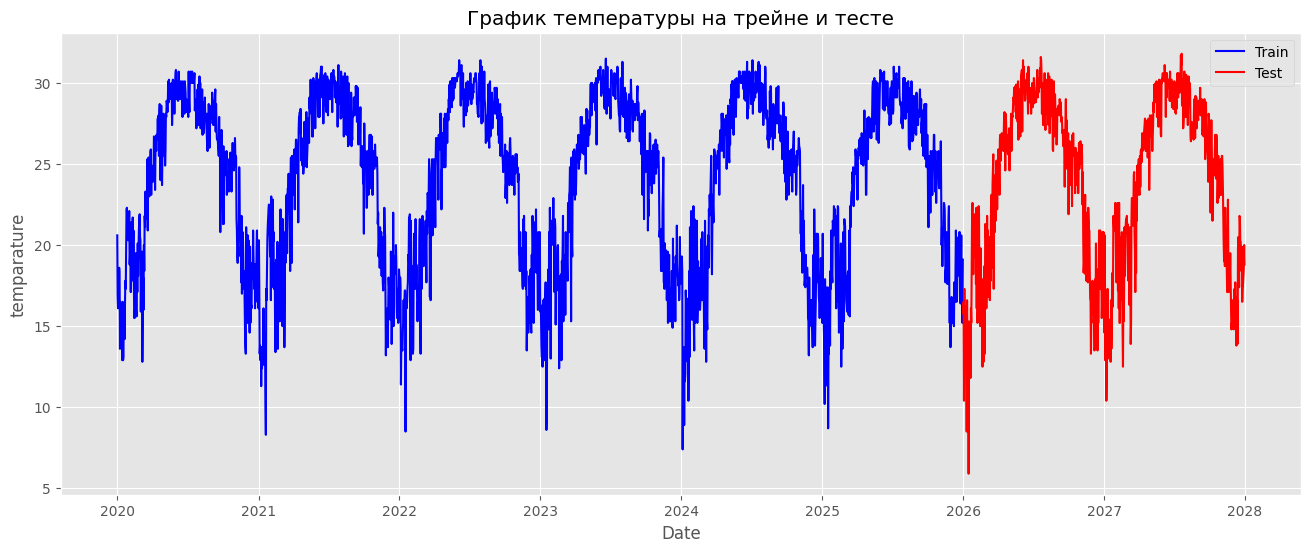

In [118]:
plot_temparature(train, test)

**На основе графиков можно сделать несколько выводов:**
1. Поле day точно обозначает день года, так как наглядно видна сезонная зависимость в данных
2. Данные разных имеют одну и ту же природу. Таким образом можно сделать предположение, что это временной ряд данных из одного физического места. (Но при это почему то отсутствуют високосные года)  
3. Данные не имеют ярко выраженных выбросов

In [119]:
def plot_numeric_cols(df, plot_type):
    """Графики числовых показателей"""

    numeric_cols = df.select_dtypes(include='number').columns[2:-2]
    plt.figure(figsize=(18,24))
    for i in range(len(numeric_cols)):
        col = numeric_cols[i]

        plt.subplot(5,2,i+1)
        plt.title(f'{col}')

        if plot_type=='plot':
            plt.plot(df[col])
        elif plot_type=='boxplot':
            g = sns.boxplot(x=df[col])
            g.set(xlabel=None)

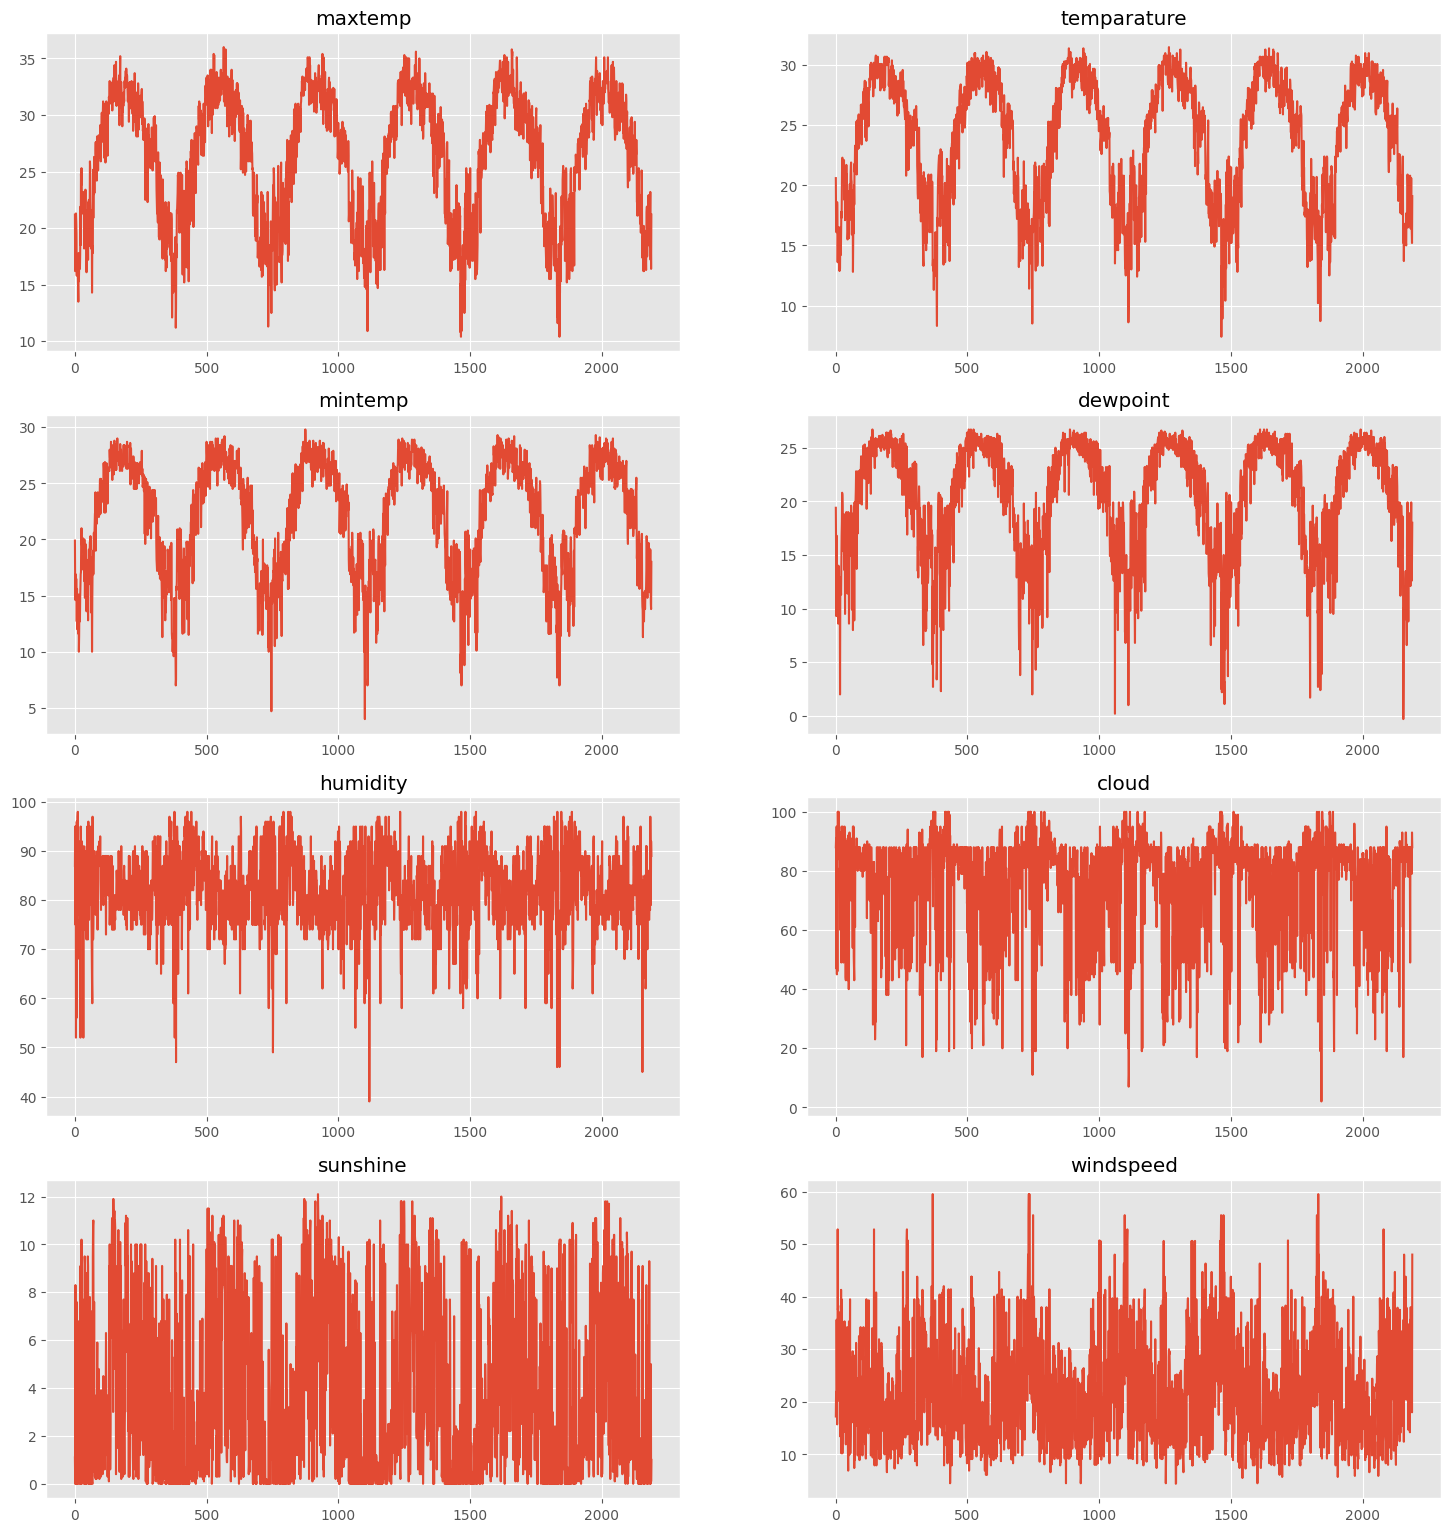

In [120]:
plot_numeric_cols(train, plot_type='plot')

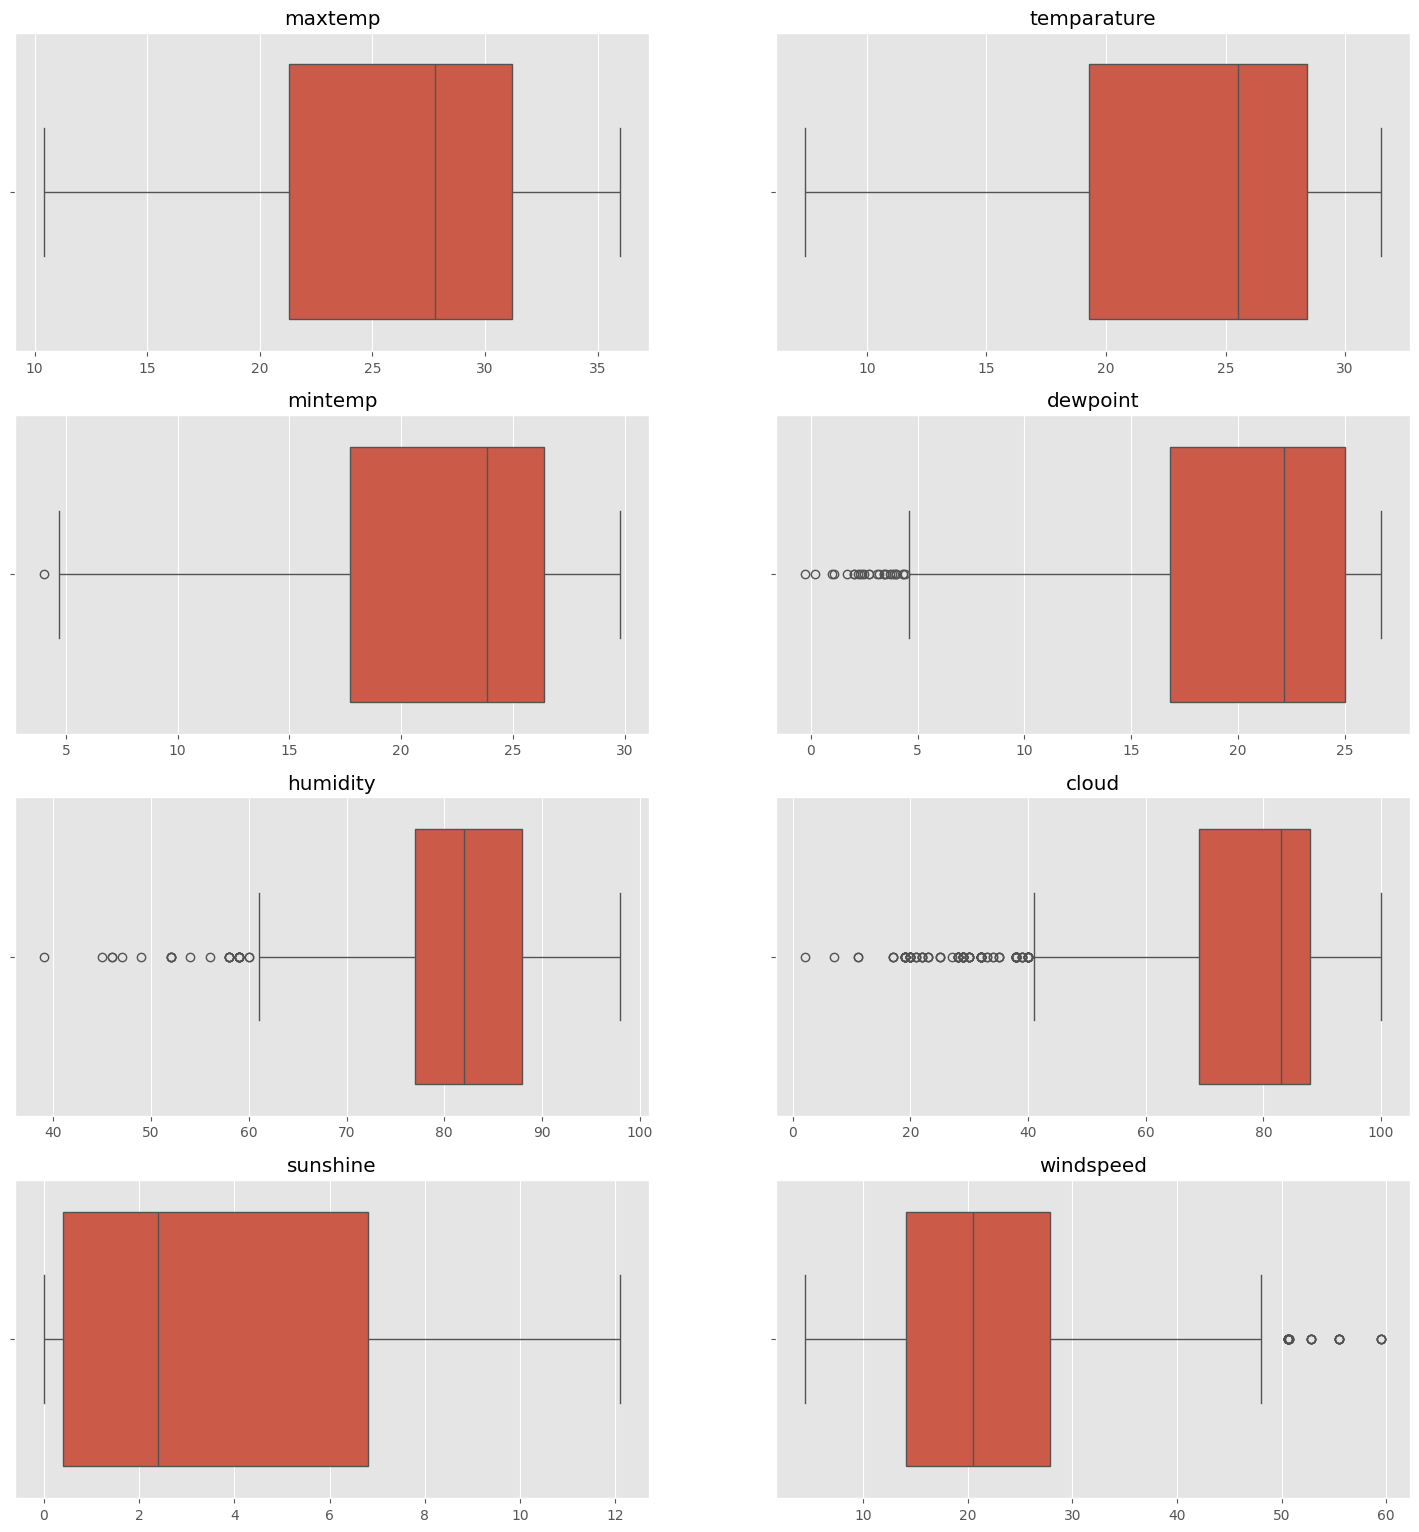

In [121]:
plot_numeric_cols(train, plot_type='boxplot')

In [122]:
def plot_numeric_cols_train_and_test(train, test):
    """Графики числовых показателей на трейне и тесте"""

    numeric_cols = train.select_dtypes(include='number').columns[2:-2]

    for i in range(len(numeric_cols)):
        plt.figure(figsize=(12,4))
        col = numeric_cols[i]

        plt.title(f'{col}')

        plt.plot(train['date'], train[col], label='Train', color='blue')
        plt.plot(test['date'], test[col], label='Test', color='red')

        plt.xlabel('Date')
        plt.legend()
        plt.grid(True)

        plt.show()

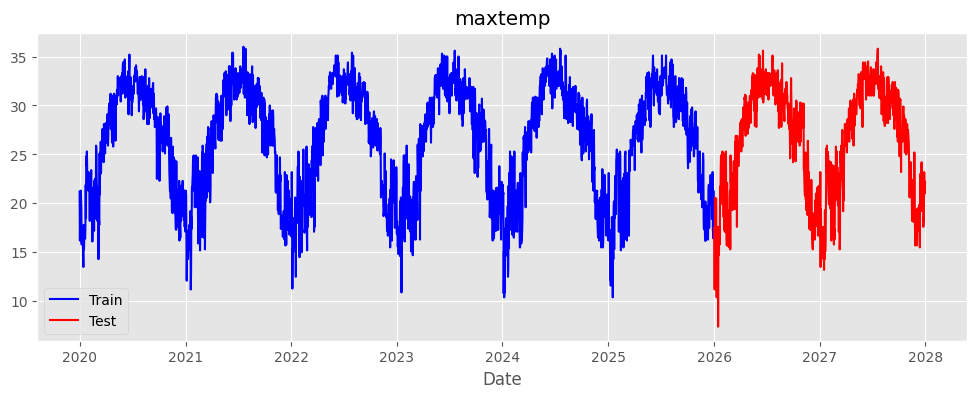

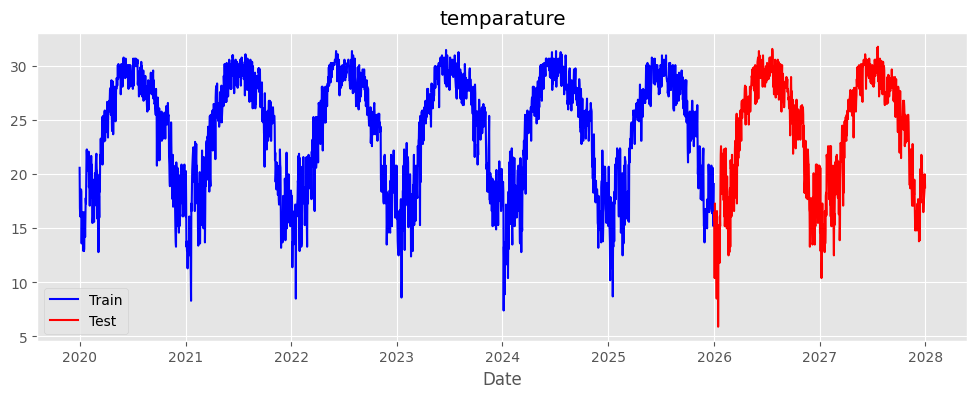

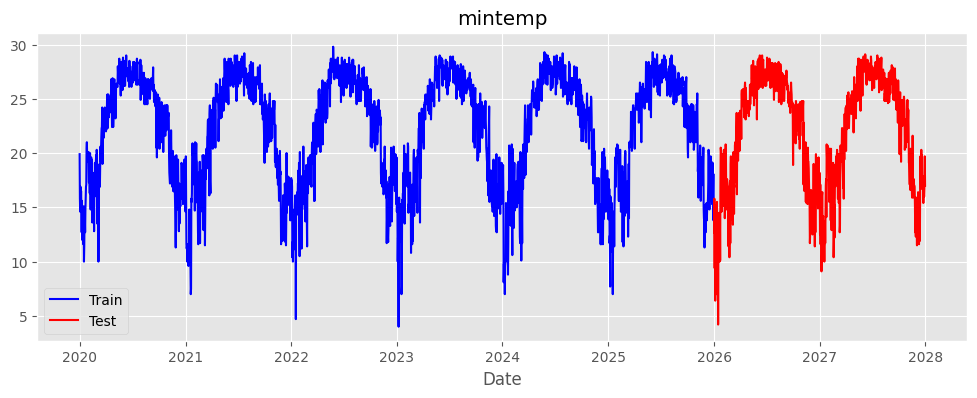

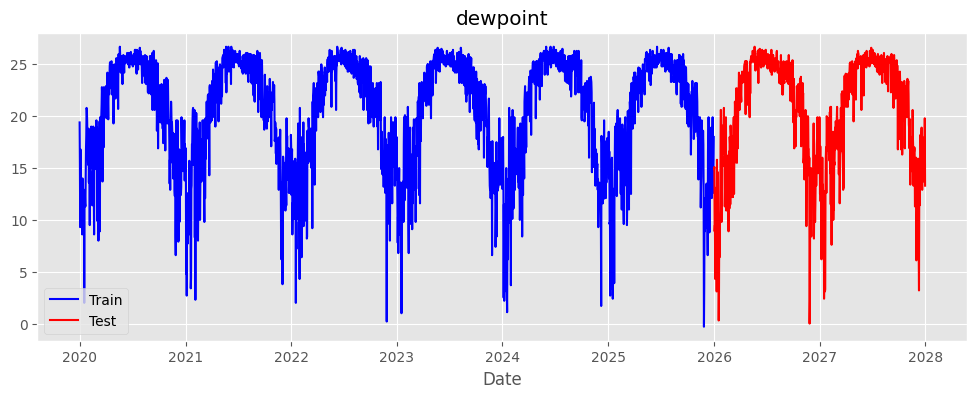

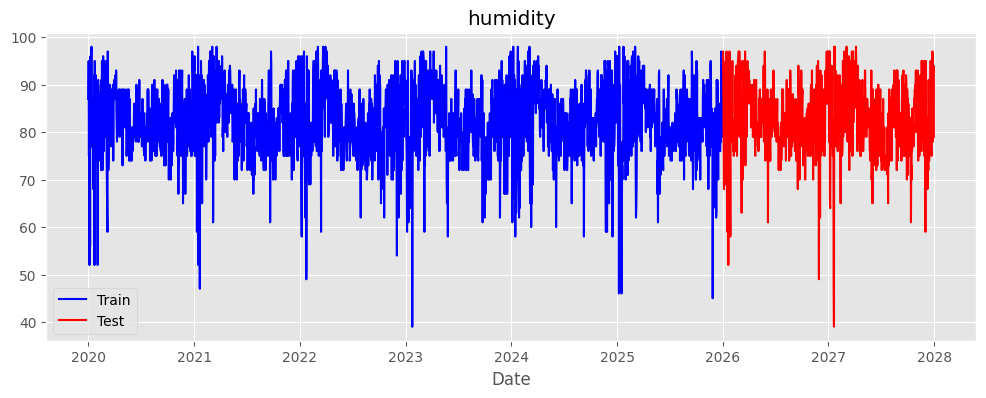

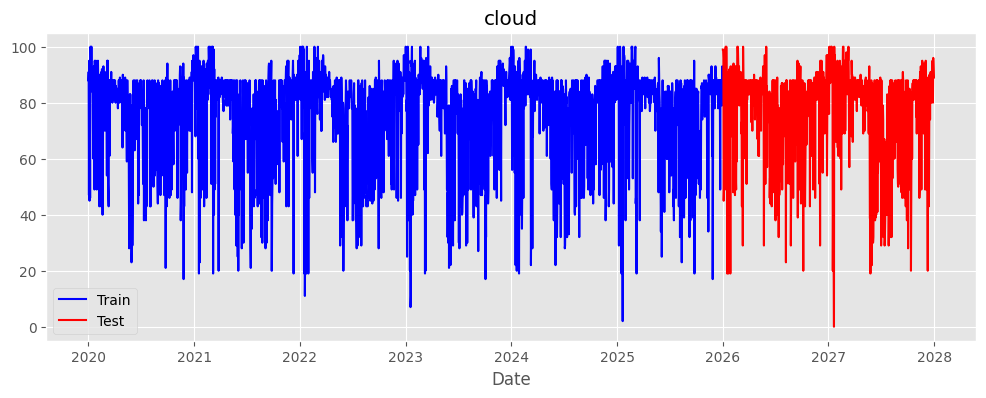

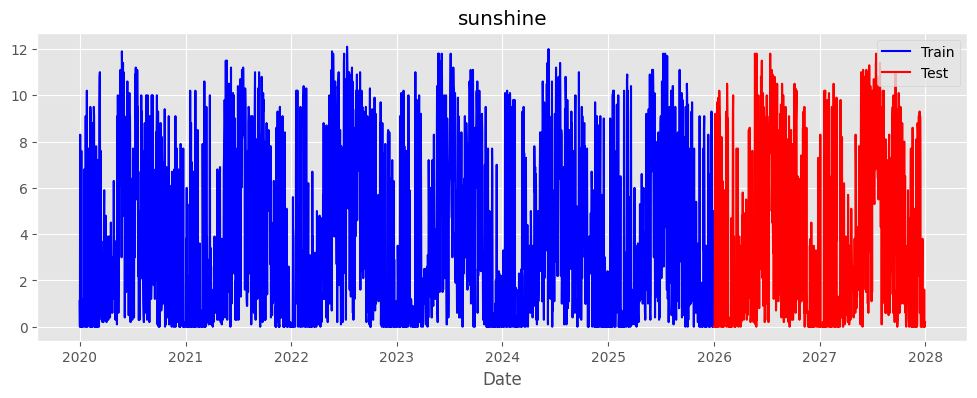

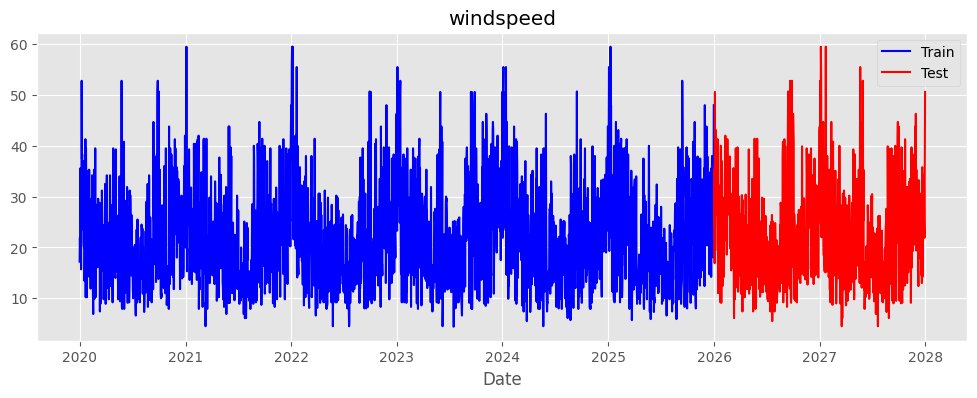

In [123]:
plot_numeric_cols_train_and_test(train, test)

#### Распределение целевой переменной

In [124]:
train['rainfall'].value_counts()

rainfall
1.0    1650
0.0     540
Name: count, dtype: int64

In [125]:
train['rainfall'].value_counts(normalize=True)

rainfall
1.0    0.753425
0.0    0.246575
Name: proportion, dtype: float64

In [126]:
for year in train['year'].unique():
    train_year = train[train['year']==year]
    rainfall_proportion = train_year['rainfall'].value_counts(normalize=True).reset_index()
    print(f'Год - {year}')
    print(rainfall_proportion)
    print(' ')

Год - 2020
   rainfall  proportion
0       1.0    0.728767
1       0.0    0.271233
 
Год - 2021
   rainfall  proportion
0       1.0    0.753425
1       0.0    0.246575
 
Год - 2022
   rainfall  proportion
0       1.0    0.745205
1       0.0    0.254795
 
Год - 2023
   rainfall  proportion
0       1.0    0.750685
1       0.0    0.249315
 
Год - 2024
   rainfall  proportion
0       1.0    0.756164
1       0.0    0.243836
 
Год - 2025
   rainfall  proportion
0       1.0    0.786301
1       0.0    0.213699
 


#### Категориальные переменные 

In [130]:
# Объединяем датасет
df_full = pd.concat([train, test])

In [131]:
df_full

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,year,date,month,season
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1.0,2020,2020-01-01,1,Winter
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1.0,2020,2020-01-02,1,Winter
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1.0,2020,2020-01-03,1,Winter
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1.0,2020,2020-01-04,1,Winter
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0.0,2020,2020-01-05,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,NaN,2027,2027-12-27,12,Winter
726,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,NaN,2027,2027-12-28,12,Winter
727,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,NaN,2027,2027-12-29,12,Winter
728,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,NaN,2027,2027-12-30,12,Winter


<Axes: ylabel='Frequency'>

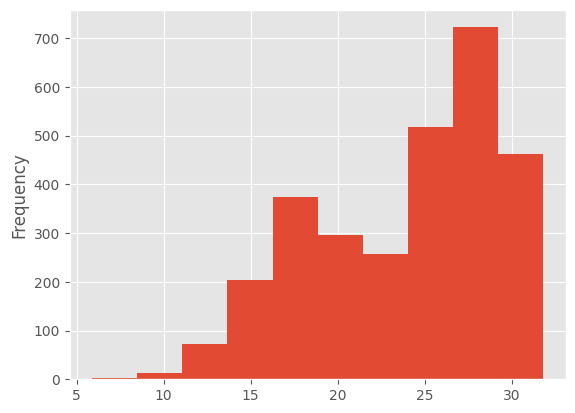

In [132]:
df_full['temparature'].plot(kind='hist')

#### Оконные переменные

In [128]:
number_cols = df_full.select_dtypes(include='number').columns[2:-2]
for col in number_cols:

    # Сдвиги на неделю
    for i in range(1,8):
        df_full[f'{col}_shift_{i}'] = df_full[col].shift(i)

    # Скользящие значения
    for j in [2,3,4,5,6,7,10,14]:
        df_full[f'{col}_mean_{j}'] = df_full[col].rolling(j).mean()
        df_full[f'{col}_std_{j}'] = df_full[col].rolling(j).std()
        df_full[f'{col}_min_{j}'] = df_full[col].rolling(j).min()
        df_full[f'{col}_max_{j}'] = df_full[col].rolling(j).max()
        df_full[f'{col}_sum_{j}'] = df_full[col].rolling(j).sum()

In [129]:
df_full

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,windspeed_mean_10,windspeed_std_10,windspeed_min_10,windspeed_max_10,windspeed_sum_10,windspeed_mean_14,windspeed_std_14,windspeed_min_14,windspeed_max_14,windspeed_sum_14
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,...,23.69,7.988387,13.0,35.8,236.9,24.771429,6.897316,13.0,35.8,346.8
726,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,...,24.75,7.323820,13.0,35.8,247.5,24.535714,6.816000,13.0,35.8,343.5
727,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,...,24.45,7.378234,13.0,35.8,244.5,24.185714,6.816593,13.0,35.8,338.6
728,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,...,27.10,7.565418,14.2,39.5,271.0,25.121429,7.948989,13.0,39.5,351.7


In [90]:
df_full['pressure'].rolling(3, min_periods=1).sum()

0      1017.4
1      2036.9
2      3061.0
3      3057.0
4      3059.3
        ...  
725    3055.2
726    3050.5
727    3055.2
728    3048.8
729    3058.0
Name: pressure, Length: 2920, dtype: float64

In [76]:
df_full

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,year,date,month,season,pressure_shift_1
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1.0,2020,2020-01-01,1,Winter,NaN
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1.0,2020,2020-01-02,1,Winter,1017.4
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1.0,2020,2020-01-03,1,Winter,1019.5
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1.0,2020,2020-01-04,1,Winter,1024.1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0.0,2020,2020-01-05,1,Winter,1013.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2915,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,NaN,2027,2027-12-27,12,Winter,1018.0
726,2916,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,NaN,2027,2027-12-28,12,Winter,1020.8
727,2917,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,NaN,2027,2027-12-29,12,Winter,1011.7
728,2918,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,NaN,2027,2027-12-30,12,Winter,1022.7


## Подготовка датасетов для обучения

In [246]:
def prepare_dataset_for_train(train, test, normalize):
    """Подготовка датасета для обучения"""

    # Объединяем трейн и тест
    df = pd.concat([train, test]).fillna(0)
    
    # Удаление лишних колонок
    df = df.drop(['id','year'], axis=1)

    # Добавление категориальной фичи месяца
    df['month_cat'] = df['month'].astype(str)
    
    # Кодировка категориальных переменных
    df = pd.get_dummies(df)

    # Переопределение типа данных
    # object_cols = ['winddirection','rainfall']
    object_cols = ['rainfall']
    for col in object_cols:
        df[col] = df[col].astype(int).astype(str)
    

    # Нормализация числовых показателей
    numeric_cols = df.select_dtypes(include='number').columns
    for col in numeric_cols:
        if normalize=='mean':
            df[col] = (df[col]-df[col].mean())/df[col].std()
        elif normalize=='min-max':
            df[col]=(df[col]-df[col].min())/(df[col].max()-df[col].min())
            
    df['rainfall'] = df['rainfall'].astype(int)
    
    x_test_final = df[df['date']>='2026.01.01'].drop(['date','rainfall'], axis=1)
    df = df[df['date']<'2026.01.01']

    # Раздление на трейн, валидацию и тест
    train_dataset = df[df['date']<'2024.01.01'].drop(['date'], axis=1)
    val_dataset = df[(df['date']>='2024.01.01')&(df['date']<'2025.01.01')].drop(['date'], axis=1)
    test_dataset = df[df['date']>='2025.01.01'].drop(['date'], axis=1)
    
    # Выделение целевой переменной
    x_train = train_dataset.drop('rainfall', axis=1)
    y_train = train_dataset['rainfall']

    x_val = val_dataset.drop('rainfall', axis=1)
    y_val = val_dataset['rainfall']

    x_test = test_dataset.drop('rainfall', axis=1)
    y_test = test_dataset['rainfall']
    
    # x_train = x_train.astype({col: 'int32' for col in x_train.select_dtypes('bool').columns})
    # x_val = x_val.astype({col: 'int32' for col in x_val.select_dtypes('bool').columns})
    # x_test = x_test.astype({col: 'int32' for col in x_test.select_dtypes('bool').columns})


    return x_train, y_train, x_val, y_val, x_test, y_test, x_test_final

In [250]:
x_train, y_train, x_val, y_val, x_test, y_test, x_test_final = prepare_dataset_for_train(train, test, normalize='min-max')

In [251]:
x_train

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,month_cat_11,month_cat_12,month_cat_2,month_cat_3,month_cat_4,month_cat_5,month_cat_6,month_cat_7,month_cat_8,month_cat_9
0,0.000000,0.516854,0.482517,0.567568,0.616279,0.729630,0.813559,0.88,0.090909,0.200000,...,False,False,False,False,False,False,False,False,False,False
1,0.002747,0.575843,0.307692,0.424710,0.457364,0.581481,0.949153,0.91,0.000000,0.166667,...,False,False,False,False,False,False,False,False,False,False
2,0.005495,0.705056,0.419580,0.393822,0.410853,0.355556,0.610169,0.47,0.685950,0.233333,...,False,False,False,False,False,False,False,False,False,False
3,0.008242,0.404494,0.374126,0.459459,0.500000,0.633333,0.949153,0.95,0.000000,0.200000,...,False,False,False,False,False,False,False,False,False,False
4,0.010989,0.640449,0.486014,0.482625,0.434109,0.366667,0.220339,0.45,0.297521,0.133333,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.989011,0.488764,0.311189,0.413127,0.461240,0.566667,0.881356,0.96,0.000000,0.233333,...,False,True,False,False,False,False,False,False,False,False
1456,0.991758,0.418539,0.402098,0.432432,0.437984,0.637037,0.677966,0.94,0.000000,0.233333,...,False,True,False,False,False,False,False,False,False,False
1457,0.994505,0.393258,0.517483,0.563707,0.585271,0.674074,0.677966,0.81,0.181818,0.233333,...,False,True,False,False,False,False,False,False,False,False
1458,0.997253,0.435393,0.395105,0.451737,0.503876,0.655556,0.983051,0.95,0.000000,0.166667,...,False,True,False,False,False,False,False,False,False,False


In [252]:
y_train

0       1
1       1
2       1
3       1
4       0
       ..
1455    1
1456    1
1457    1
1458    1
1459    1
Name: rainfall, Length: 1460, dtype: int32

## Обучение

In [253]:
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Импорт моделей
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [254]:
def objective(trial):
    # Выбираем тип модели для данного испытания
    model_name = trial.suggest_categorical("model", 
        ["RandomForest", "XGBoost", "LightGBM", "CatBoost", "GradientBoosting",
         "LogisticRegression", "KNeighbors", "NaiveBayes", "SVM"])
    # model_name = trial.suggest_categorical("model", 
    #     ["SVM"])
    
    if model_name == "RandomForest":
        n_estimators = trial.suggest_int("rf_n_estimators", 50, 300)
        max_depth = trial.suggest_int("rf_max_depth", 3, 20)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        
    elif model_name == "XGBoost":
        n_estimators = trial.suggest_int("xgb_n_estimators", 50, 300)
        max_depth = trial.suggest_int("xgb_max_depth", 3, 10)
        learning_rate = trial.suggest_loguniform("xgb_learning_rate", 1e-3, 1e-1)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                learning_rate=learning_rate, use_label_encoder=False,
                                eval_metric='logloss', verbosity=0, random_state=42)

    elif model_name == "LightGBM":
        n_estimators = trial.suggest_int("lgb_n_estimators", 50, 300)
        max_depth = trial.suggest_int("lgb_max_depth", 3, 10)
        learning_rate = trial.suggest_loguniform("lgb_learning_rate", 1e-3, 1e-1)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                learning_rate=learning_rate, verbose=-1, random_state=42)

    elif model_name == "CatBoost":
        n_estimators = trial.suggest_int("cb_n_estimators", 50, 300)
        depth = trial.suggest_int("cb_depth", 3, 12)
        learning_rate = trial.suggest_loguniform("cb_learning_rate", 1e-3, 1e-1)
        model = cb.CatBoostClassifier(iterations=n_estimators, depth=depth, 
                                    learning_rate=learning_rate, verbose=0, random_state=42)
        
    elif model_name == "GradientBoosting":
        n_estimators = trial.suggest_int("gb_n_estimators", 50, 300)
        max_depth = trial.suggest_int("gb_max_depth", 3, 10)
        learning_rate = trial.suggest_loguniform("gb_learning_rate", 1e-3, 1e-1)
        model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                           learning_rate=learning_rate, random_state=42)

    # Простые модели
    elif model_name == "LogisticRegression":
        C = trial.suggest_loguniform("lr_C", 1e-3, 1e3)
        model = LogisticRegression(C=C, solver='liblinear', random_state=42)

    elif model_name == "KNeighbors":
        n_neighbors = trial.suggest_int("knn_n_neighbors", 1, 20)
        model = KNeighborsClassifier(n_neighbors=n_neighbors)

    elif model_name == "NaiveBayes":
        model = GaussianNB()  # Наивный байес не имеет гиперпараметров в стандартном виде

    elif model_name == "SVM":
        C = trial.suggest_loguniform("svm_C", 1e-3, 1e3)
        kernel = trial.suggest_categorical("svm_kernel", ["linear", "rbf", "poly"])
        model = SVC(C=C, kernel=kernel, probability=True, random_state=42)

    # Обучение и предсказание
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    return auc

In [255]:
# Создаём и запускаем исследование Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)

# Вывод лучших параметров и результата
print("Best trial:")
trial = study.best_trial
print("  AUC: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-03-03 14:48:43,635] A new study created in memory with name: no-name-d4a6e177-41e3-4e5a-bc85-ddfb89233983
[I 2025-03-03 14:48:43,646] Trial 0 finished with value: 0.8786842533789285 and parameters: {'model': 'LogisticRegression', 'lr_C': 0.03503098362352133}. Best is trial 0 with value: 0.8786842533789285.
[I 2025-03-03 14:48:43,655] Trial 1 finished with value: 0.882795961569777 and parameters: {'model': 'LogisticRegression', 'lr_C': 96.1038601573735}. Best is trial 1 with value: 0.882795961569777.
[I 2025-03-03 14:48:44,106] Trial 2 finished with value: 0.8719671063344733 and parameters: {'model': 'RandomForest', 'rf_n_estimators': 173, 'rf_max_depth': 18}. Best is trial 1 with value: 0.882795961569777.
[I 2025-03-03 14:48:44,970] Trial 3 finished with value: 0.8755902947402704 and parameters: {'model': 'CatBoost', 'cb_n_estimators': 289, 'cb_depth': 6, 'cb_learning_rate': 0.00104327045625217}. Best is trial 1 with value: 0.882795961569777.
[I 2025-03-03 14:48:44,987] Trial 4

Best trial:
  AUC: 0.8878439993486403
  Params: 
    model: LogisticRegression
    lr_C: 1.1156219748122047


In [292]:
def evaluate_model(model, x_test, y_test, treshhold):
    """
    Оценивает качество обученной модели на тестовых данных.
    
    Параметры:
    - model: лучшая модель из Optuna
    - x_test: тестовые признаки
    - y_test: тестовые метки

    Выводит метрики и матрицу ошибок.
    """
    # Получаем предсказанные вероятности
    y_pred_proba = model.predict_proba(x_test)[:, 1]  # Берем вероятность класса 1

    # Получаем бинарные предсказания (порог 0.5)
    y_pred = (y_pred_proba >= treshhold).astype(int)

    # Расчет метрик
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Вывод результатов
    print(f"ROC-AUC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

### Params: 
    model: CatBoost  
    cb_n_estimators: 261  
    cb_depth: 6  
    cb_learning_rate: 0.06634789518887471

### Params:
    model: SVM
    svm_C: 0.280035010065635
    svm_kernel: poly

In [298]:
best_model = cb.CatBoostClassifier(n_estimators=261, depth=4, learning_rate=0.06634789518887471, verbose=0, random_state=42)
# best_model = LogisticRegression(C=1.1156219748122047, solver='liblinear', random_state=42)
best_model.fit(x_train, y_train)
evaluate_model(best_model, x_test, y_test, treshhold=0.7)  # Оценка модели на тесте
print(' ')
evaluate_model(best_model, x_val, y_val, treshhold=0.7)  # Оценка модели на тесте

ROC-AUC: 0.8685
Accuracy: 0.8438
F1-score: 0.8980
Precision: 0.9228
Recall: 0.8746
Confusion Matrix:
[[ 57  21]
 [ 36 251]]
 
ROC-AUC: 0.8887
Accuracy: 0.8575
F1-score: 0.9055
Precision: 0.9088
Recall: 0.9022
Confusion Matrix:
[[ 64  25]
 [ 27 249]]


In [299]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,cloud,27.988365
1,sunshine,13.762764
2,humidity,10.986494
3,dewpoint,8.147694
4,windspeed,7.965740
5,mintemp,6.234850
6,day,5.095279
7,pressure,4.257847
8,maxtemp,4.248506
9,temparature,3.644148


In [300]:
x_train_full = pd.concat([x_train, x_val, x_test])
y_train_full = pd.concat([y_train, y_val, y_test])

# best_model.fit(x_train_full, y_train_full)
best_model.fit(x_train, y_train)

In [301]:
# Получаем предсказанные вероятности
y_pred_proba = best_model.predict_proba(x_test_final)[:, 1]  # Берем вероятность класса 1

# Получаем бинарные предсказания (порог 0.5)
y_pred = (y_pred_proba >= 0.5).astype(int)

In [302]:
y_pred.shape

(730,)

In [303]:
sample_submission['rainfall'] = y_pred

In [304]:
sample_submission.to_csv('predicts/v3.csv', index=False)

In [306]:
sample_submission['rainfall'].value_counts(normalize=True)

rainfall
1    0.780822
0    0.219178
Name: proportion, dtype: float64

In [271]:
sample_submission_1 = pd.read_csv('predicts/v1.csv')
sample_submission_2 = pd.read_csv('predicts/v2.csv')
sample_submission_2 = sample_submission_2.rename(columns={'rainfall':'rainfall_2'})

sample_submission_full = pd.concat([sample_submission_1, sample_submission_2], axis=1)
sample_submission_full['compare'] = sample_submission_full['rainfall'] == sample_submission_full['rainfall_2']

In [275]:
sample_submission_full[sample_submission_full['compare']==False]

,id,rainfall,id,rainfall_2,compare
22,2212,0,2212,1,False
25,2215,0,2215,1,False
64,2254,0,2254,1,False
165,2355,0,2355,1,False
173,2363,1,2363,0,False
194,2384,0,2384,1,False
195,2385,1,2385,0,False
209,2399,0,2399,1,False
230,2420,1,2420,0,False
252,2442,0,2442,1,False


,id,rainfall
0,2190,1
1,2191,1
2,2192,1
3,2193,0
4,2194,0
...,...,...
725,2915,1
726,2916,1
727,2917,1
728,2918,1
